<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/Face_age_estimation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array

In [3]:
# Define a function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255.0
    return image

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_group(age):
    return age // 3

Image preprocessing

In [6]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
image_paths = []
age_labels = []

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    image_path = os.path.join(image_dir, filename)
    image_paths.append(image_path)
    age_labels.append(age)

images = np.array([preprocess_image(img_path) for img_path in image_paths])
age_groups = np.array([age_to_group(age) for age in age_labels])

In [7]:
print(f'number of images : {len(images)}')

number of images : 9931


In [8]:
import pandas as pd
df = pd.DataFrame()
df['images_path'],df['age'] = image_paths,age_labels
df.head(10)

images_path  age
0  /content/drive/MyDrive/Dataset/part1/28_1_0_20...   28
1  /content/drive/MyDrive/Dataset/part1/35_0_0_20...   35
2  /content/drive/MyDrive/Dataset/part1/38_0_4_20...   38
3  /content/drive/MyDrive/Dataset/part1/50_1_0_20...   50
4  /content/drive/MyDrive/Dataset/part1/20_1_2_20...   20
5  /content/drive/MyDrive/Dataset/part1/35_0_4_20...   35
6  /content/drive/MyDrive/Dataset/part1/57_0_0_20...   57
7  /content/drive/MyDrive/Dataset/part1/51_0_0_20...   51
8  /content/drive/MyDrive/Dataset/part1/36_1_0_20...   36
9  /content/drive/MyDrive/Dataset/part1/39_0_0_20...   39

Exploratory data analysis

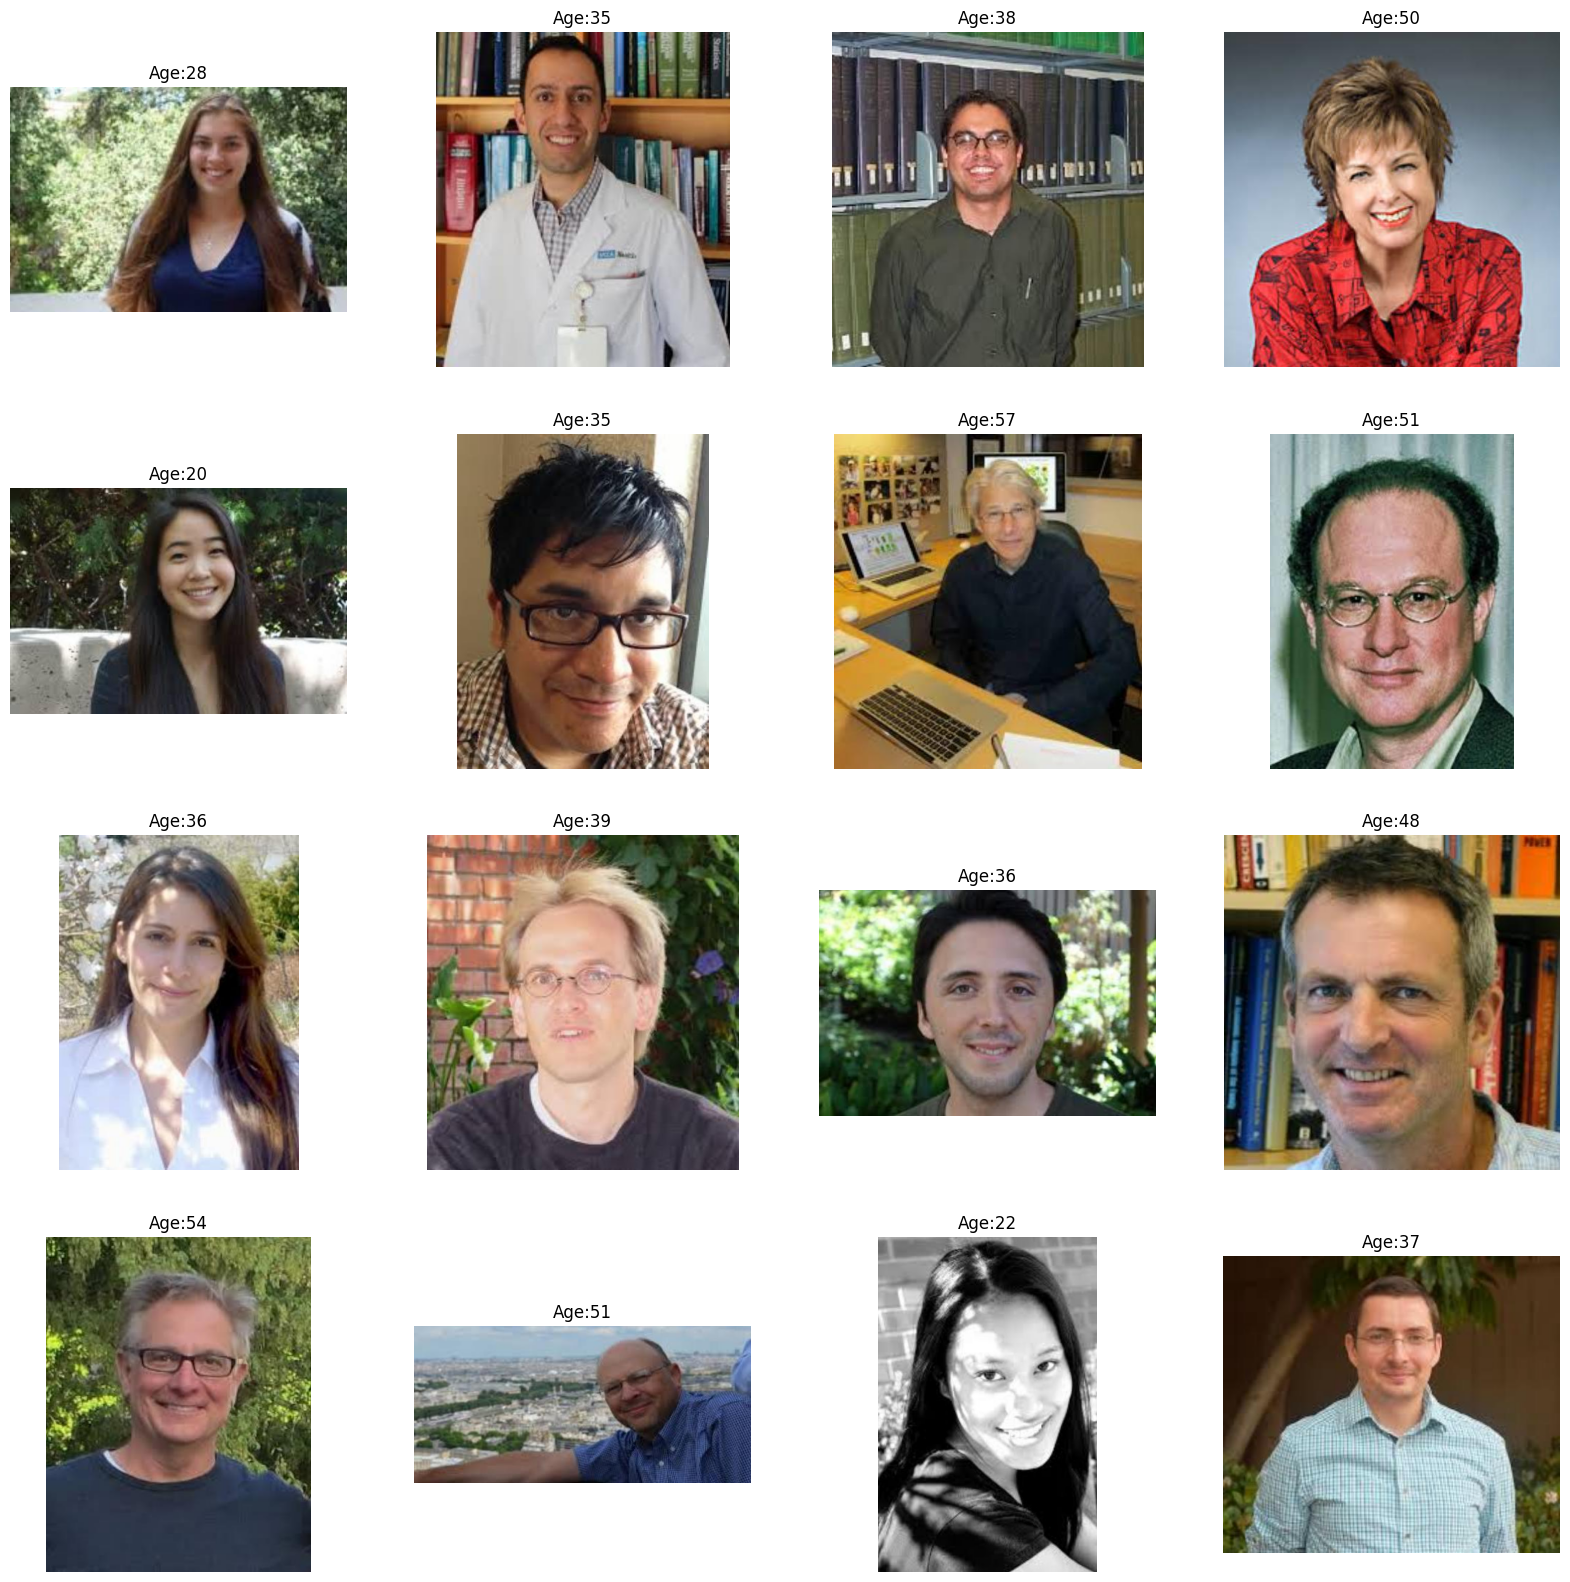

In [9]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

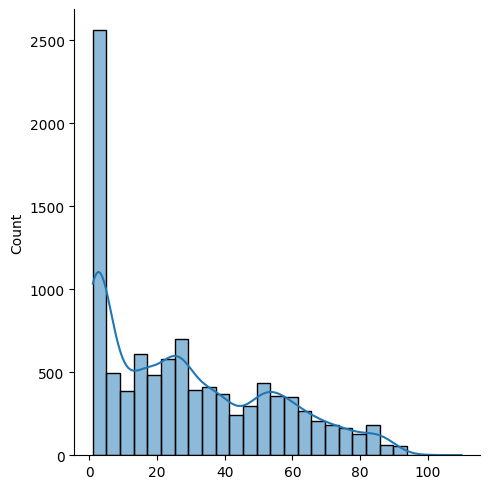

In [10]:
#age distribution
sns.displot(data=age_labels,kde=True)

Split data

In [11]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_groups, test_size=0.2, random_state=42)


Compile the model

In [12]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

age_group_indices = [age // 3 for age in age_groups]  # Convert ages to 3-year interval indices
num_classes = np.max(age_groups) + 1
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


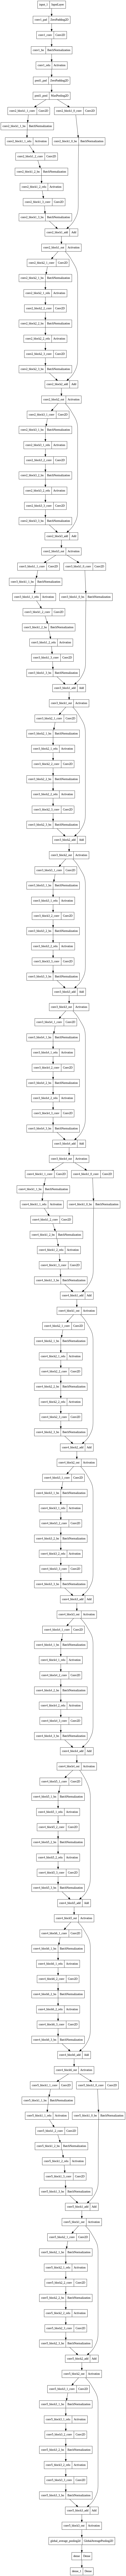

In [13]:
from keras.utils import plot_model
plot_model(model)

SetUp Callbacks

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_age_group_model.h5', save_best_only=True, monitor='val_loss')


Train the model

In [16]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
199/199 [==============================] - ETA: 0s - loss: 2.7915 - accuracy: 0.2197

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 43s 214ms/step - loss: 2.7915 - accuracy: 0.2197 - val_loss: 3.6518 - val_accuracy: 0.0346
Epoch 2/50
199/199 [==============================] - 35s 178ms/step - loss: 2.3911 - accuracy: 0.2670 - val_loss: 3.3320 - val_accuracy: 0.0743
Epoch 3/50
199/199 [==============================] - 34s 172ms/step - loss: 2.1849 - accuracy: 0.2993 - val_loss: 3.3383 - val_accuracy: 0.0566
Epoch 4/50
199/199 [==============================] - 36s 179ms/step - loss: 2.0960 - accuracy: 0.3212 - val_loss: 2.8021 - val_accuracy: 0.1932
Epoch 5/50
199/199 [==============================] - 34s 173ms/step - loss: 1.9659 - accuracy: 0.3435 - val_loss: 3.6092 - val_accuracy: 0.2335
Epoch 6/50
199/199 [==============================] - 36s 180ms/step - loss: 1.8500 - accuracy: 0.3726 - val_loss: 2.5862 - val_accuracy: 0.2687
Epoch 7/50
199/199 [==============================] - 35s 174ms/step - loss: 1.7026 - accuracy: 0.4074 - val_loss: 2.8853 - val_accuracy: 0.2

Load best model and evaluate

In [17]:
# Load the best model
model.load_weights('best_age_group_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


63/63 [==============================] - 4s 59ms/step - loss: 2.4954 - accuracy: 0.2793
Test Accuracy: 27.93%
